In [1]:
import os 
os.chdir("/nas/ucb/oliveradk/diverse-gen/")

In [2]:
import yaml 
import json
from pathlib import Path
from itertools import product

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from diverse_gen.utils.exp_utils import get_conf_dir

In [3]:
OUT_DIR = Path("output/dbat_aux_weight_sweep/2025-02-21_09-01-41") # 2025-02-20_15-08-19
MIX_RATES = [0.1, 0.25, 0.5, 0.75, 1.0]
DATASETS = ["toy_grid", "fmnist_mnist", "cifar_mnist", "waterbirds"]
METHODS = ["DBAT"]
N_TRIALS = 32



In [11]:
all_results = []
not_found_configs = []
for (ds_name, mix_rate) in product(DATASETS, MIX_RATES):
    for i in range(N_TRIALS):
        exp_dir = get_conf_dir((ds_name, mix_rate, i), OUT_DIR)
        metrics_path = Path(exp_dir, "metrics.json")
        config_path = Path(exp_dir, "config.yaml")
        if not metrics_path.exists():
            print(f"ds_name: {ds_name} i: {i}")
            not_found_configs.append((ds_name, i))
            continue
        with open(metrics_path, "r") as f:
            metrics = json.load(f)
        with open(config_path, "r") as f:
            config = yaml.safe_load(f)
        min_val_loss_epoch = np.argmin(np.array(metrics["val_weighted_loss"]))
        val_loss = metrics["val_weighted_loss"][min_val_loss_epoch]
        source_acc = metrics["val_source_acc_0"][min_val_loss_epoch]
        source_loss = metrics["val_source_loss"][min_val_loss_epoch]
        test_acc = metrics["test_acc_0"][min_val_loss_epoch]
        # source_loss = metrics["val_source_loss_0"][min_val_loss_epoch]
        all_results.append({
            "dataset": ds_name,
            "aux_weight": config["aux_weight"],
            "mix_rate": mix_rate,
            "lr": config["lr"],
            "val_weighted_loss": val_loss,
            "source_loss": source_loss,
            "source_acc": source_acc,
            "test_acc": test_acc,
        })

df = pd.DataFrame(all_results, columns=["dataset", "aux_weight", "mix_rate", "lr", "val_weighted_loss", "source_loss", "source_acc", "test_acc"])

In [15]:
df.groupby('dataset').agg({
    'source_loss': ['mean', 'std']
}).round(4)

source_loss        
                    mean     std
dataset                         
cifar_mnist       0.0550  0.1345
fmnist_mnist      0.0792  0.1963
toy_grid          0.0454  0.1198
waterbirds        0.1676  0.1383

In [5]:
df["aux_weight"].max()

0.6493816315762113

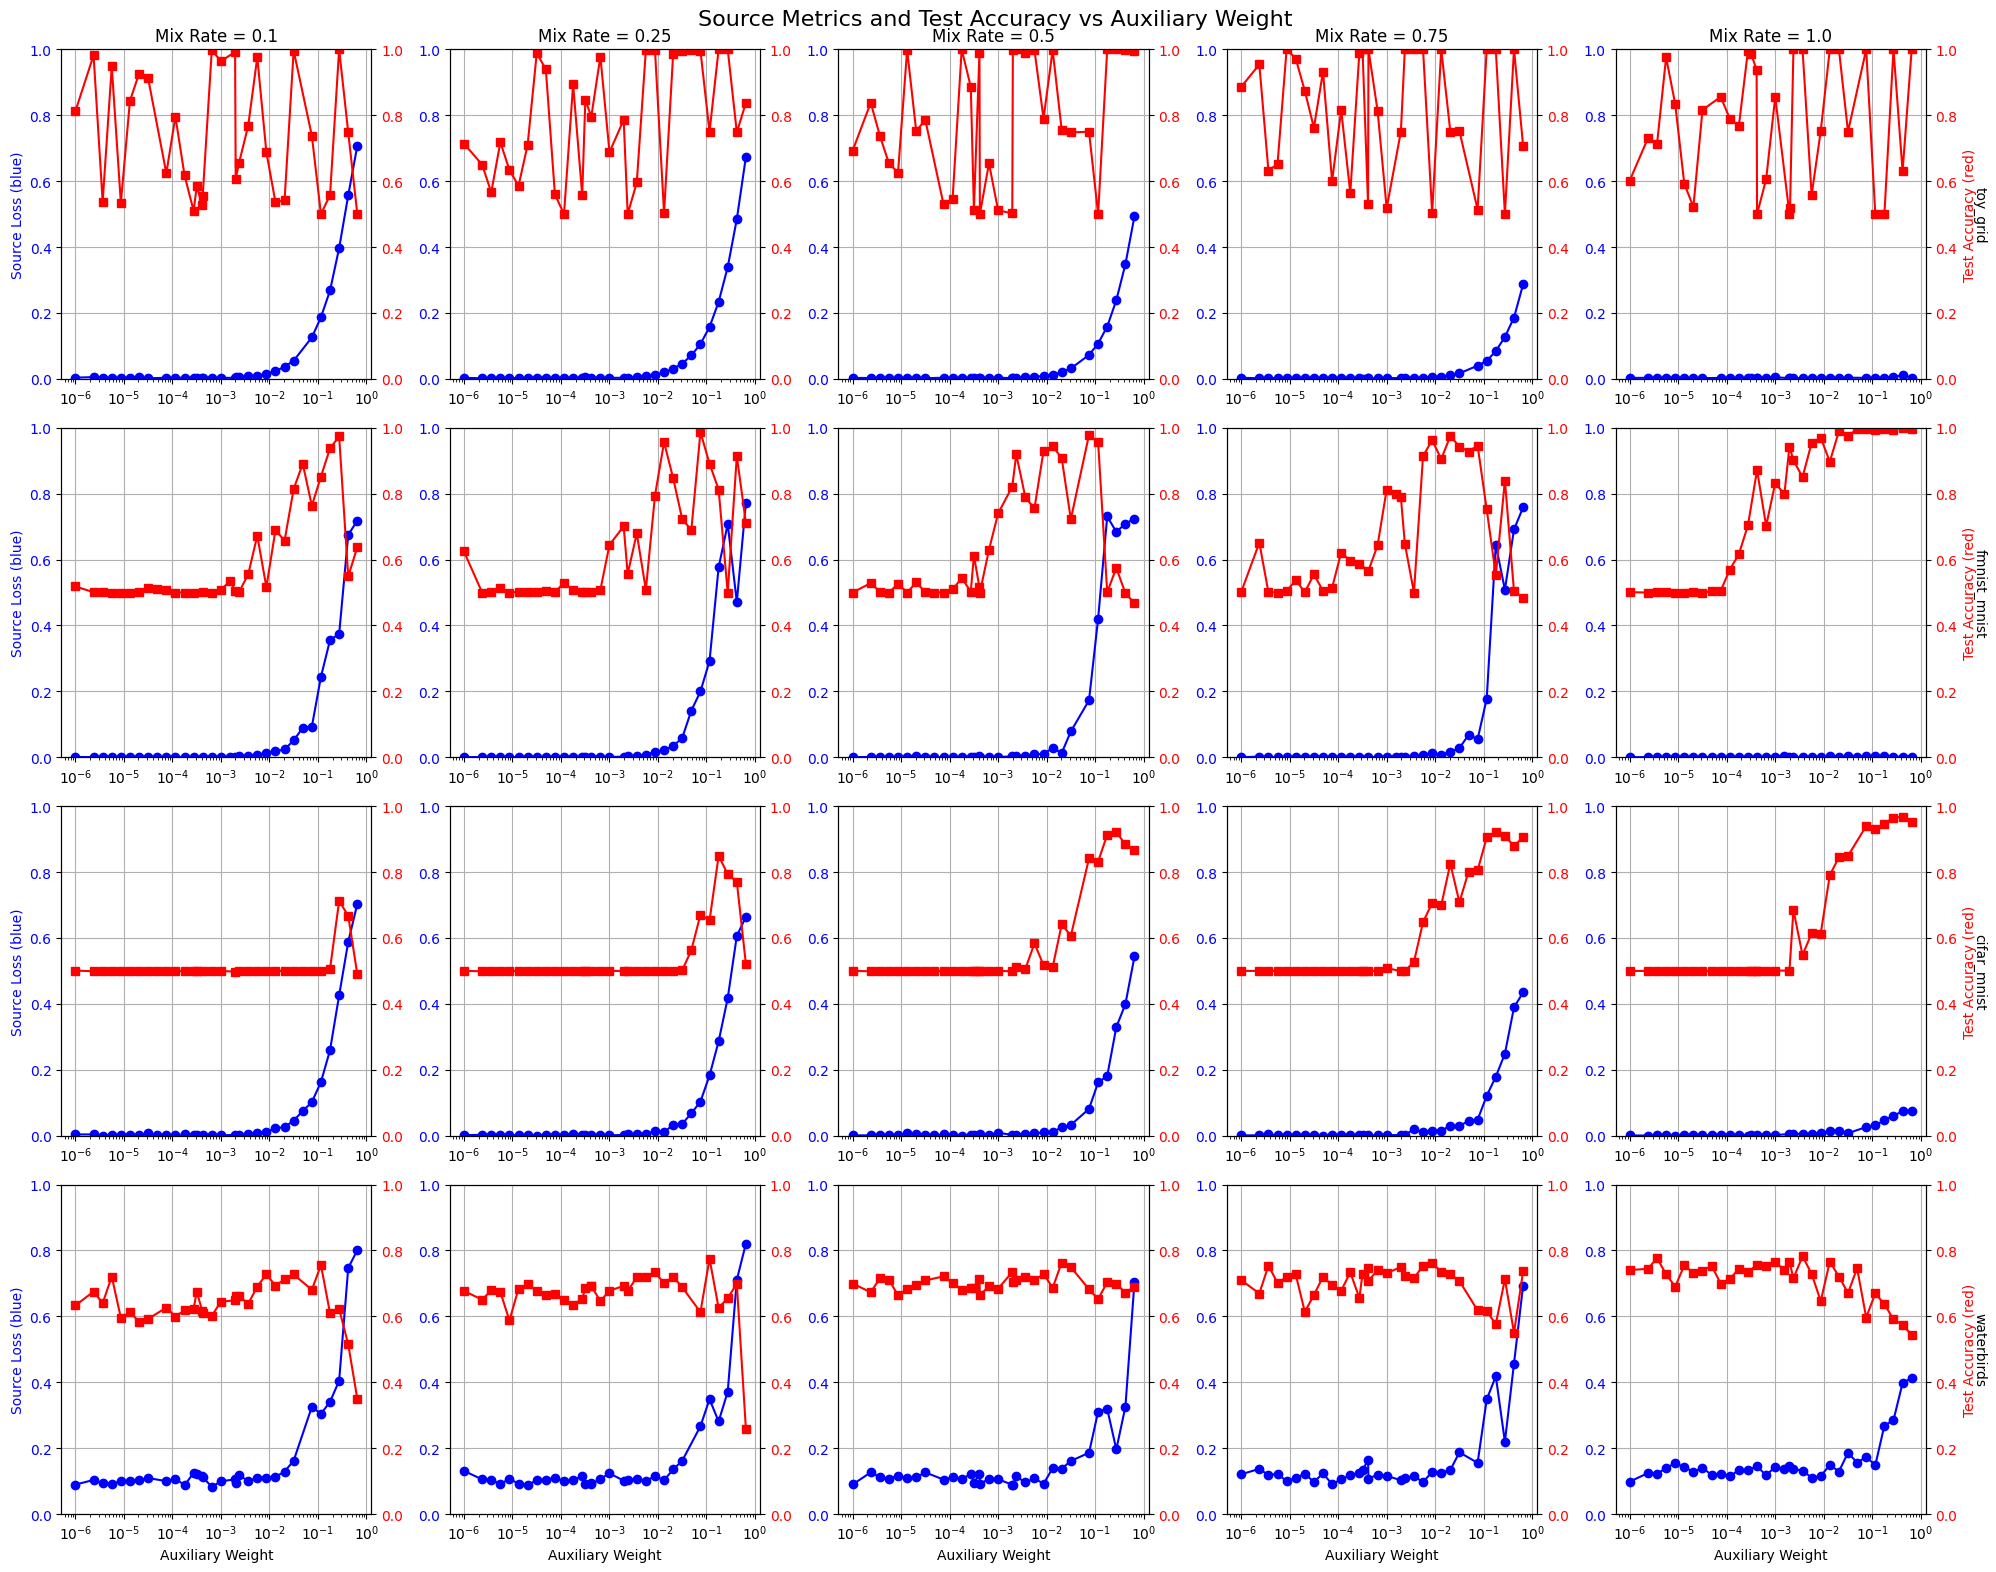

In [17]:
def plot_metrics(df, DATASETS, MIX_RATES, plot_source_loss=False):
    # Create a subplot grid
    fig, axes = plt.subplots(len(DATASETS), len(MIX_RATES), figsize=(20, 16))
    fig.suptitle('Source Metrics and Test Accuracy vs Auxiliary Weight', fontsize=16)
    
    source_metric = 'source_loss' if plot_source_loss else 'source_acc'
    source_label = 'Source Loss' if plot_source_loss else 'Source Accuracy'
    # For source loss, we want higher y-limits and reversed (smaller is better)
    source_ylim = (0.0, 1.0) if plot_source_loss else (0.97, 1.0)

    # Iterate through datasets (rows) and mix rates (columns)
    for i, dataset in enumerate(DATASETS):
        for j, mix_rate in enumerate(MIX_RATES):
            ax = axes[i, j]
            ax2 = ax.twinx()  # Create a twin axis
            
            # Filter for specific mix rate and dataset
            dataset_df = df[(df['dataset'] == dataset) & (df['mix_rate'] == mix_rate)]
            
            # Plot source metric on left axis
            grouped_source = dataset_df.groupby('aux_weight')[source_metric].agg(['mean', 'std']).reset_index()
            ax.errorbar(grouped_source['aux_weight'], grouped_source['mean'], yerr=grouped_source['std'],
                       marker='o', capsize=5, label=source_label, color='blue')
            
            # Plot test accuracy on right axis
            grouped_test = dataset_df.groupby('aux_weight')['test_acc'].agg(['mean', 'std']).reset_index()
            ax2.errorbar(grouped_test['aux_weight'], grouped_test['mean'], yerr=grouped_test['std'],
                        marker='s', capsize=5, label='Test Acc', color='red')
            
            ax.set_xscale('log')
            ax.grid(True)
            
            # Set y-axis limits for both axes
            ax.set_ylim(*source_ylim)
            ax2.set_ylim(0.0, 1.0)  # Test accuracy range
            
            # Add labels
            if i == len(DATASETS)-1:  # Bottom row
                ax.set_xlabel('Auxiliary Weight')
            if j == 0:  # Leftmost column
                ax.set_ylabel(f'{source_label} (blue)', color='blue')
            if j == len(MIX_RATES)-1:  # Rightmost column
                ax2.set_ylabel('Test Accuracy (red)', color='red')
                ax.text(1.15, 0.5, dataset, rotation=-90, 
                       transform=ax.transAxes, va='center')
            
            # Add titles
            if i == 0:  # Top row
                ax.set_title(f'Mix Rate = {mix_rate}')
            
            # Color the tick labels to match their respective lines
            ax.tick_params(axis='y', labelcolor='blue')
            ax2.tick_params(axis='y', labelcolor='red')

    plt.tight_layout()
    plt.show()

# Example usage:
# Plot with source accuracy
# plot_metrics(df, DATASETS, MIX_RATES, plot_source_loss=False)

# Plot with source loss
plot_metrics(df, DATASETS, MIX_RATES, plot_source_loss=True)

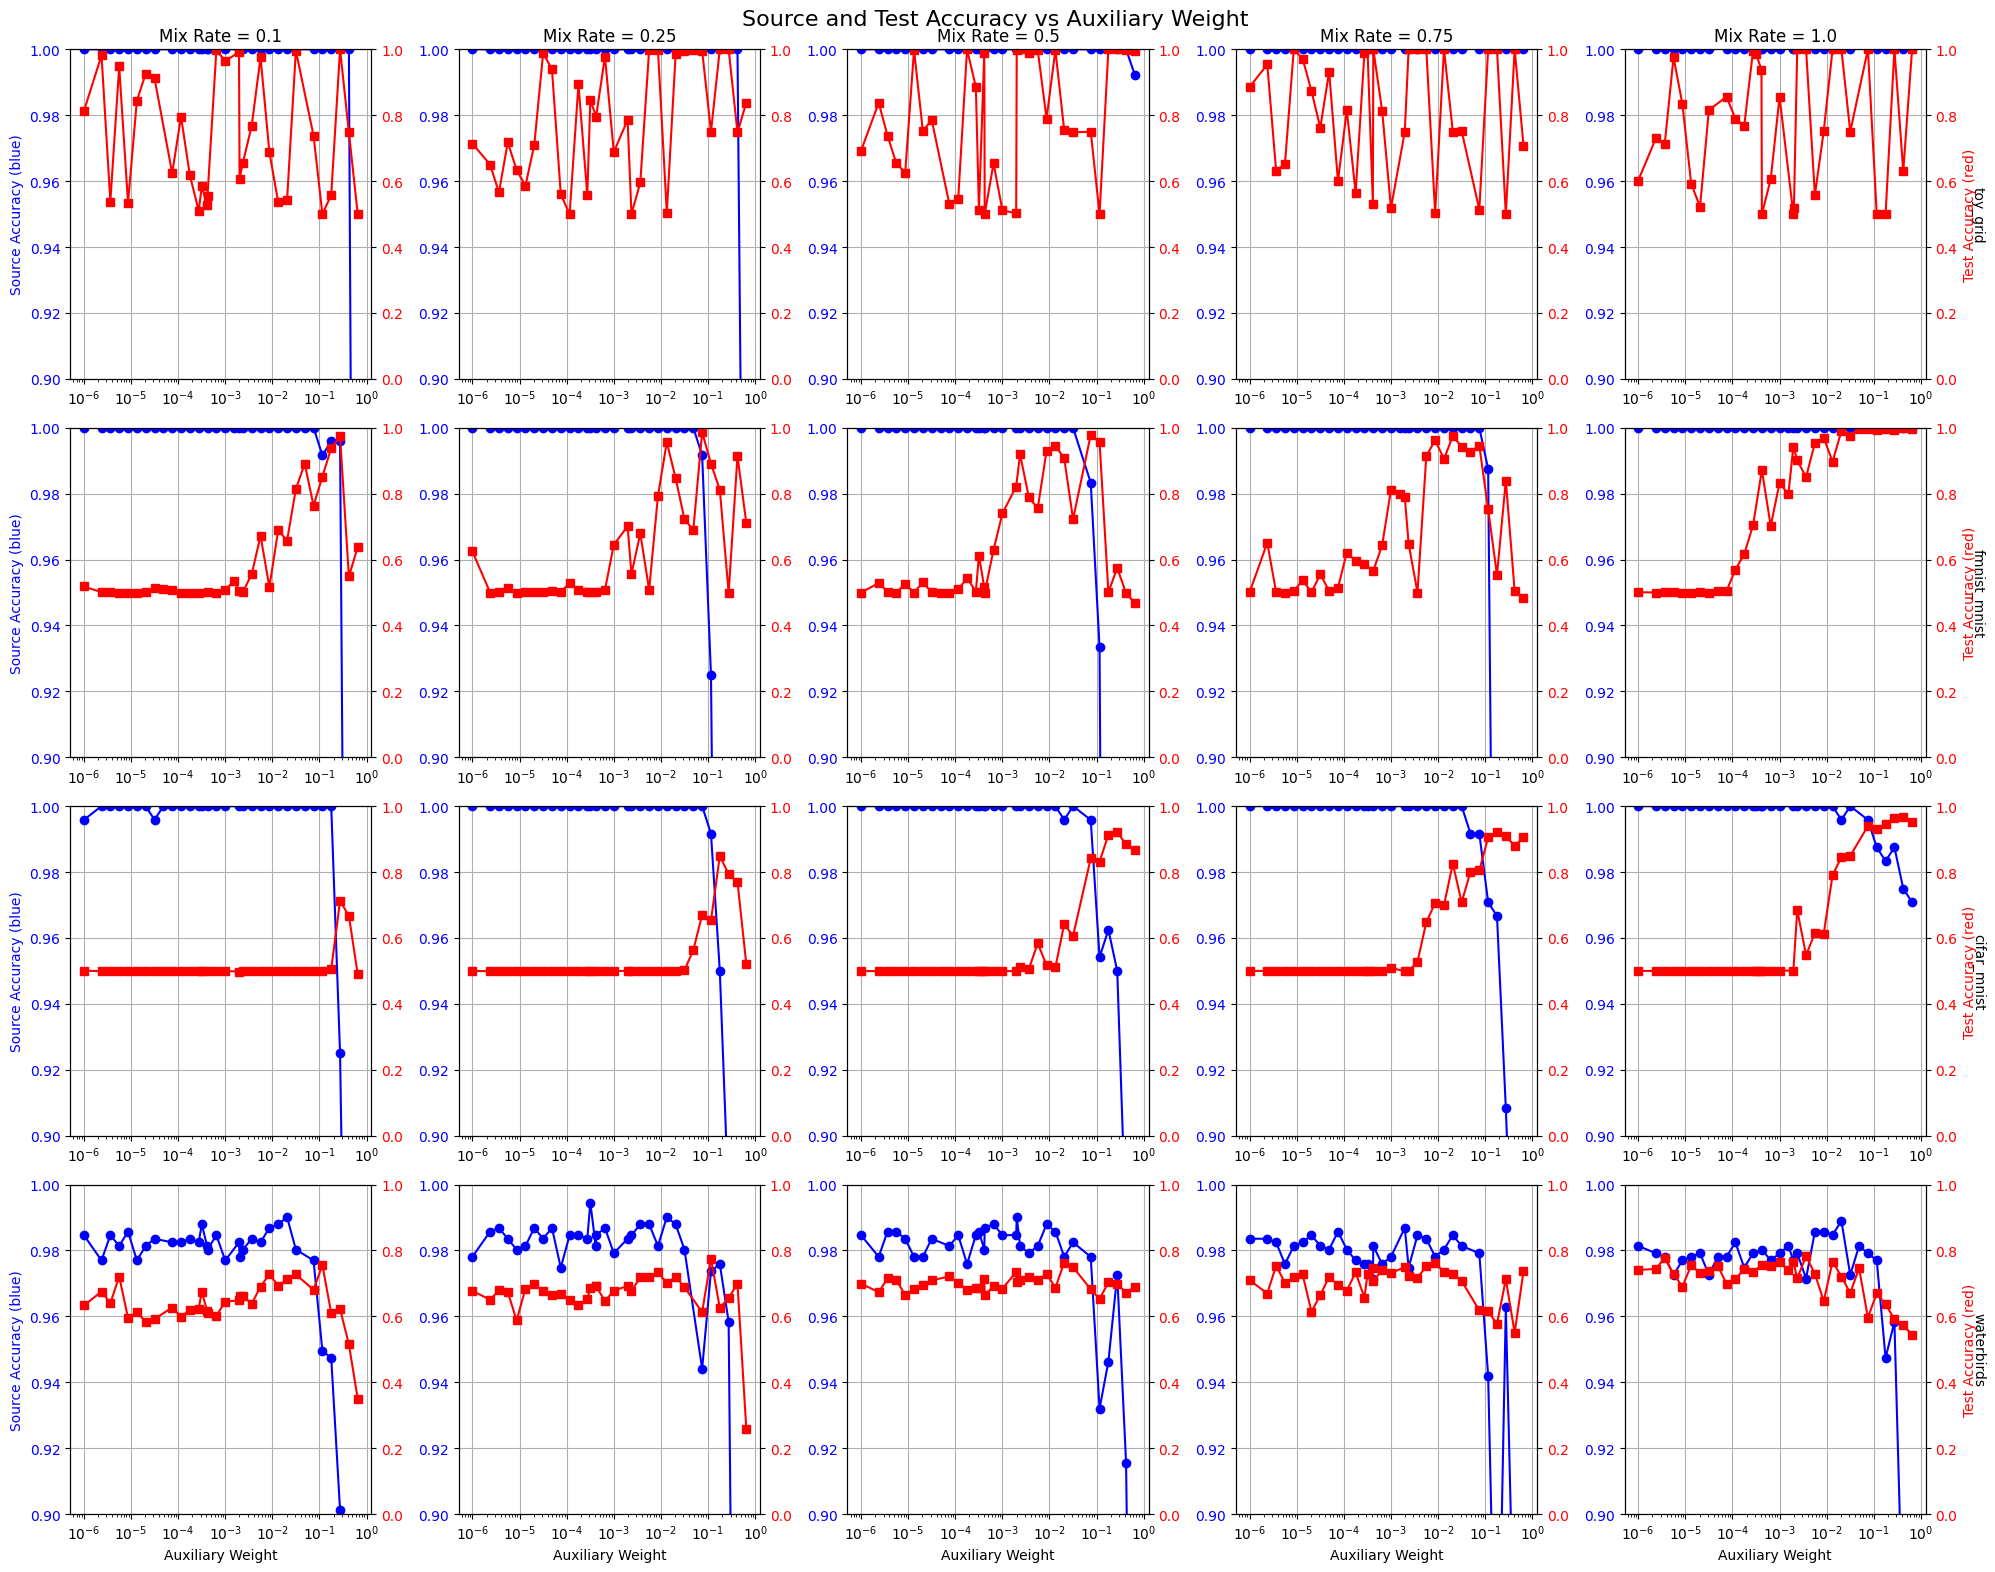

In [13]:
# Create a subplot grid
fig, axes = plt.subplots(len(DATASETS), len(MIX_RATES), figsize=(20, 16))
fig.suptitle('Source and Test Accuracy vs Auxiliary Weight', fontsize=16)

# Iterate through datasets (rows) and mix rates (columns)
for i, dataset in enumerate(DATASETS):
    for j, mix_rate in enumerate(MIX_RATES):
        ax = axes[i, j]
        ax2 = ax.twinx()  # Create a twin axis
        
        # Filter for specific mix rate and dataset
        dataset_df = df[(df['dataset'] == dataset) & (df['mix_rate'] == mix_rate)]
        
        # Plot source accuracy on left axis
        grouped_source = dataset_df.groupby('aux_weight')['source_acc'].agg(['mean', 'std']).reset_index()
        ax.errorbar(grouped_source['aux_weight'], grouped_source['mean'], yerr=grouped_source['std'],
                   marker='o', capsize=5, label='Source Acc', color='blue')
        
        # Plot test accuracy on right axis
        grouped_test = dataset_df.groupby('aux_weight')['test_acc'].agg(['mean', 'std']).reset_index()
        ax2.errorbar(grouped_test['aux_weight'], grouped_test['mean'], yerr=grouped_test['std'],
                    marker='s', capsize=5, label='Test Acc', color='red')
        
        ax.set_xscale('log')
        ax.grid(True)
        
        # Set y-axis limits for both axes
        ax.set_ylim(0.90, 1.0)
        ax2.set_ylim(0.0, 1.0)  # Wider range for test accuracy
        
        # Add labels
        if i == len(DATASETS)-1:  # Bottom row
            ax.set_xlabel('Auxiliary Weight')
        if j == 0:  # Leftmost column
            ax.set_ylabel('Source Accuracy (blue)', color='blue')
        if j == len(MIX_RATES)-1:  # Rightmost column
            ax2.set_ylabel('Test Accuracy (red)', color='red')
            ax.text(1.15, 0.5, dataset, rotation=-90, 
                   transform=ax.transAxes, va='center')
        
        # Add titles
        if i == 0:  # Top row
            ax.set_title(f'Mix Rate = {mix_rate}')
        
        # Color the tick labels to match their respective lines
        ax.tick_params(axis='y', labelcolor='blue')
        ax2.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
plt.show()

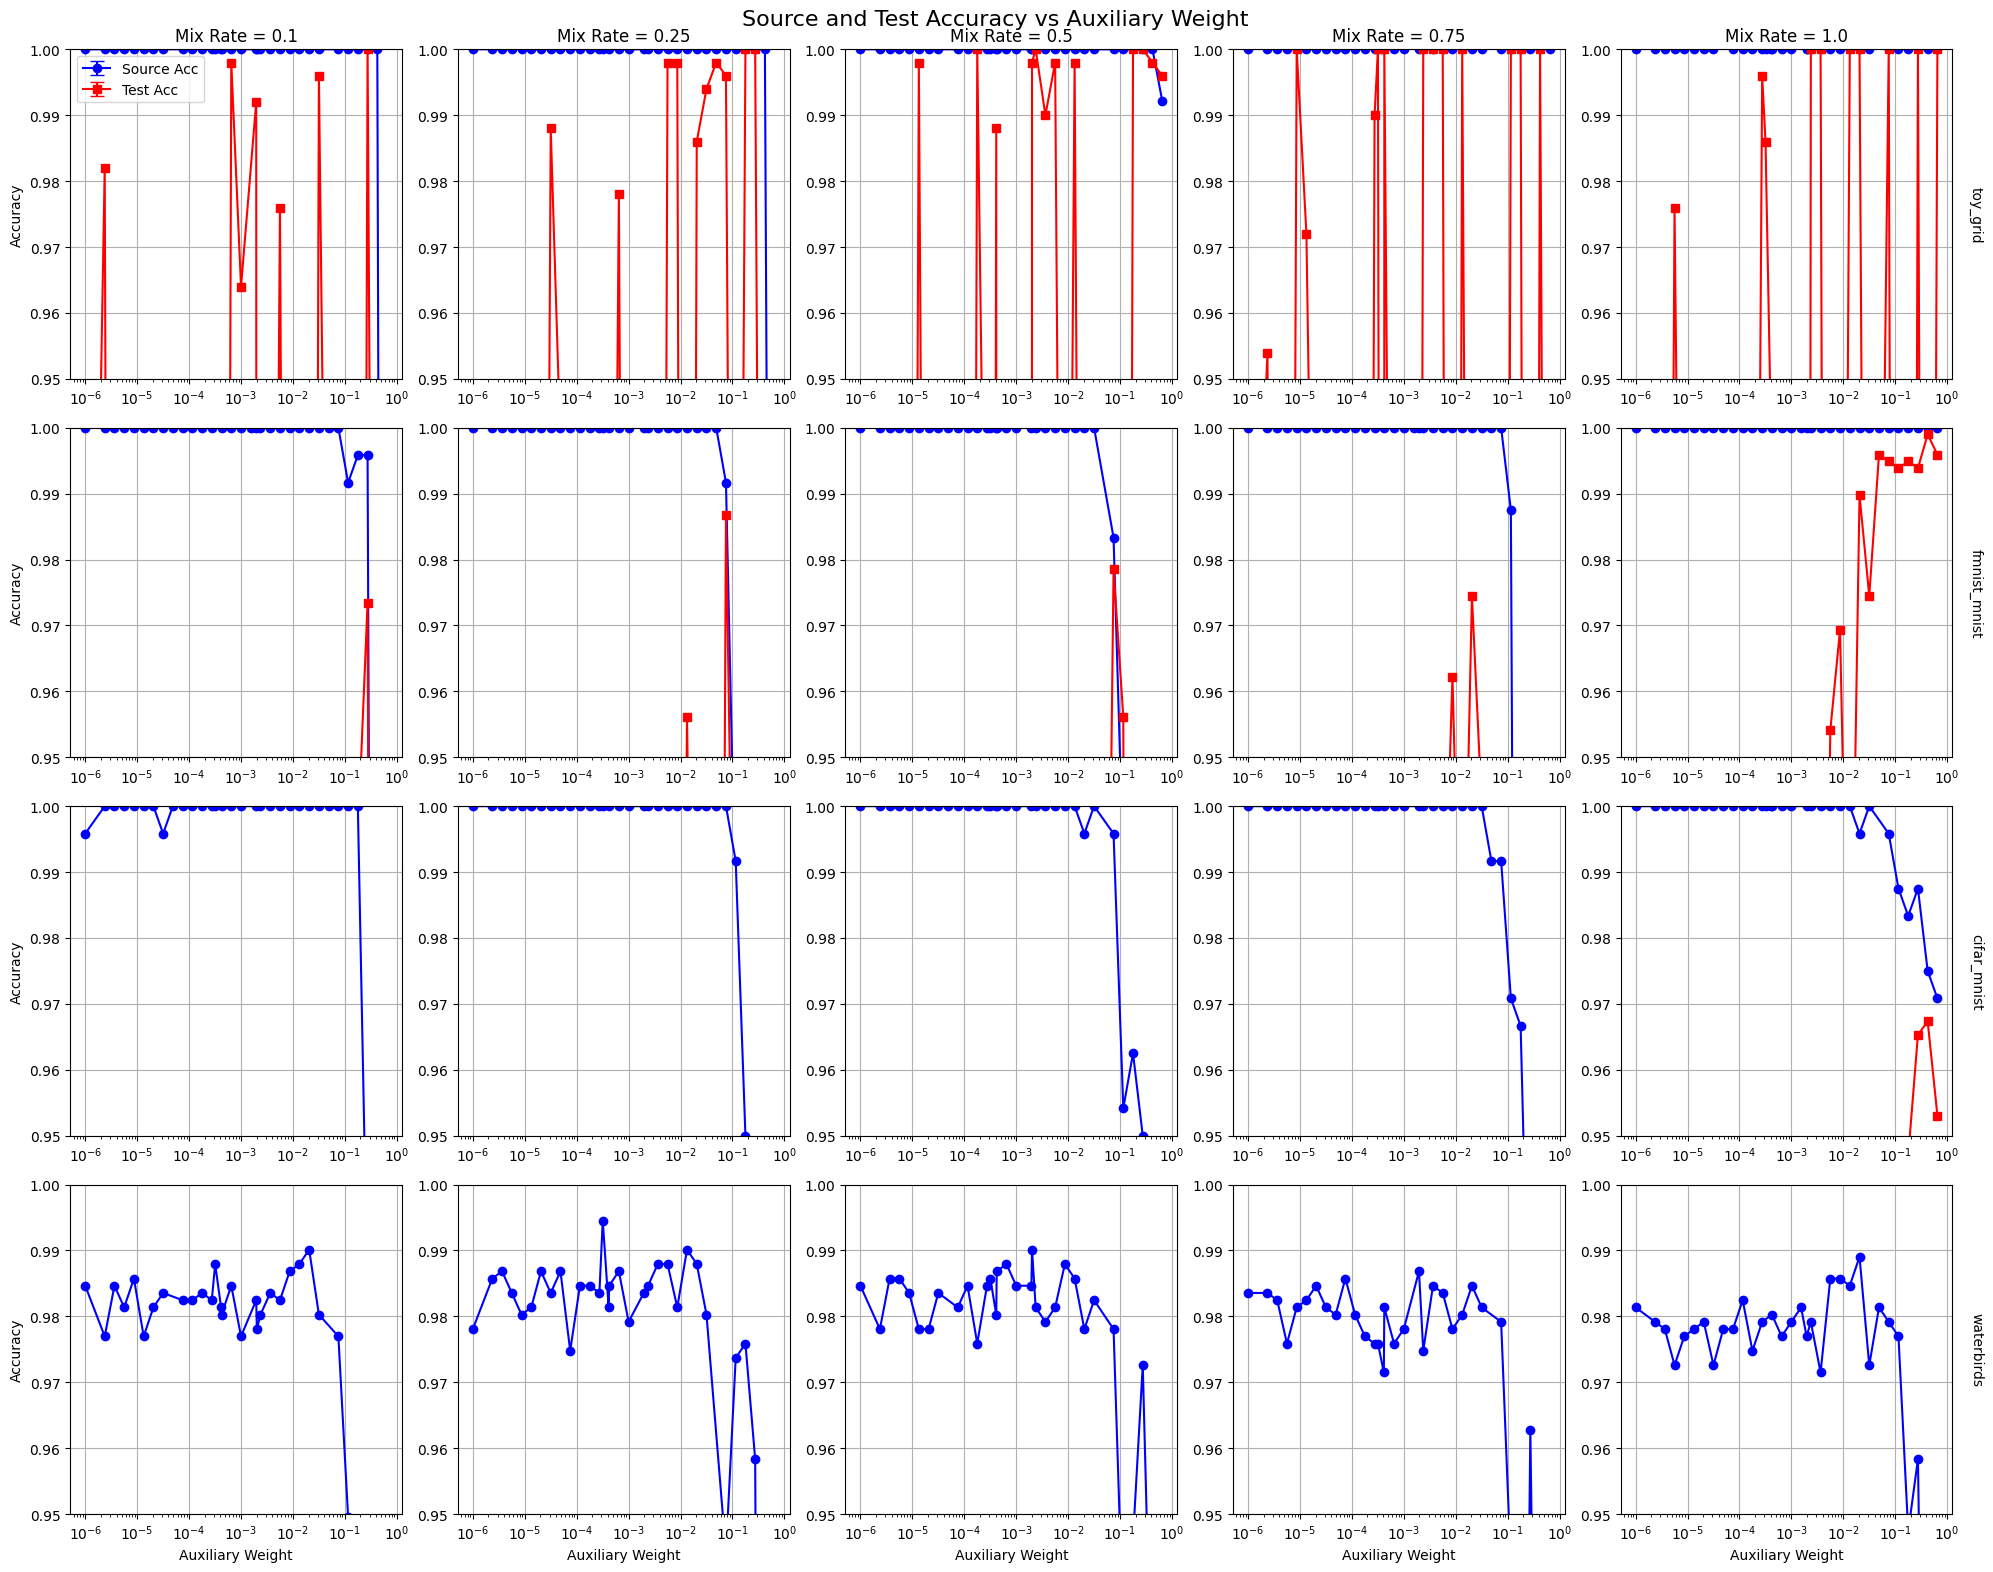

In [10]:
# Create a subplot grid
fig, axes = plt.subplots(len(DATASETS), len(MIX_RATES), figsize=(20, 16))
fig.suptitle('Source and Test Accuracy vs Auxiliary Weight', fontsize=16)

# Iterate through datasets (rows) and mix rates (columns)
for i, dataset in enumerate(DATASETS):
    for j, mix_rate in enumerate(MIX_RATES):
        ax = axes[i, j]
        
        # Filter for specific mix rate and dataset
        dataset_df = df[(df['dataset'] == dataset) & (df['mix_rate'] == mix_rate)]
        
        # Plot source accuracy
        grouped_source = dataset_df.groupby('aux_weight')['source_acc'].agg(['mean', 'std']).reset_index()
        ax.errorbar(grouped_source['aux_weight'], grouped_source['mean'], yerr=grouped_source['std'],
                   marker='o', capsize=5, label='Source Acc', color='blue')
        
        # Plot test accuracy
        grouped_test = dataset_df.groupby('aux_weight')['test_acc'].agg(['mean', 'std']).reset_index()
        ax.errorbar(grouped_test['aux_weight'], grouped_test['mean'], yerr=grouped_test['std'],
                   marker='s', capsize=5, label='Test Acc', color='red')
        
        ax.set_xscale('log')
        ax.grid(True)
        
        # Add labels
        if i == len(DATASETS)-1:  # Bottom row
            ax.set_xlabel('Auxiliary Weight')
        if j == 0:  # Leftmost column
            ax.set_ylabel('Accuracy')
            
        # Add titles
        if i == 0:  # Top row
            ax.set_title(f'Mix Rate = {mix_rate}')
        if j == len(MIX_RATES)-1:  # Rightmost column
            ax.text(1.05, 0.5, dataset, rotation=-90, 
                   transform=ax.transAxes, va='center')
        
        # Add legend only to the first subplot
        if i == 0 and j == 0:
            ax.legend()
        
        # Adjust y-axis limits to accommodate both metrics
        ax.set_ylim(0.95, 1.0)  # You might want to adjust these limits based on your data

plt.tight_layout()
plt.show()

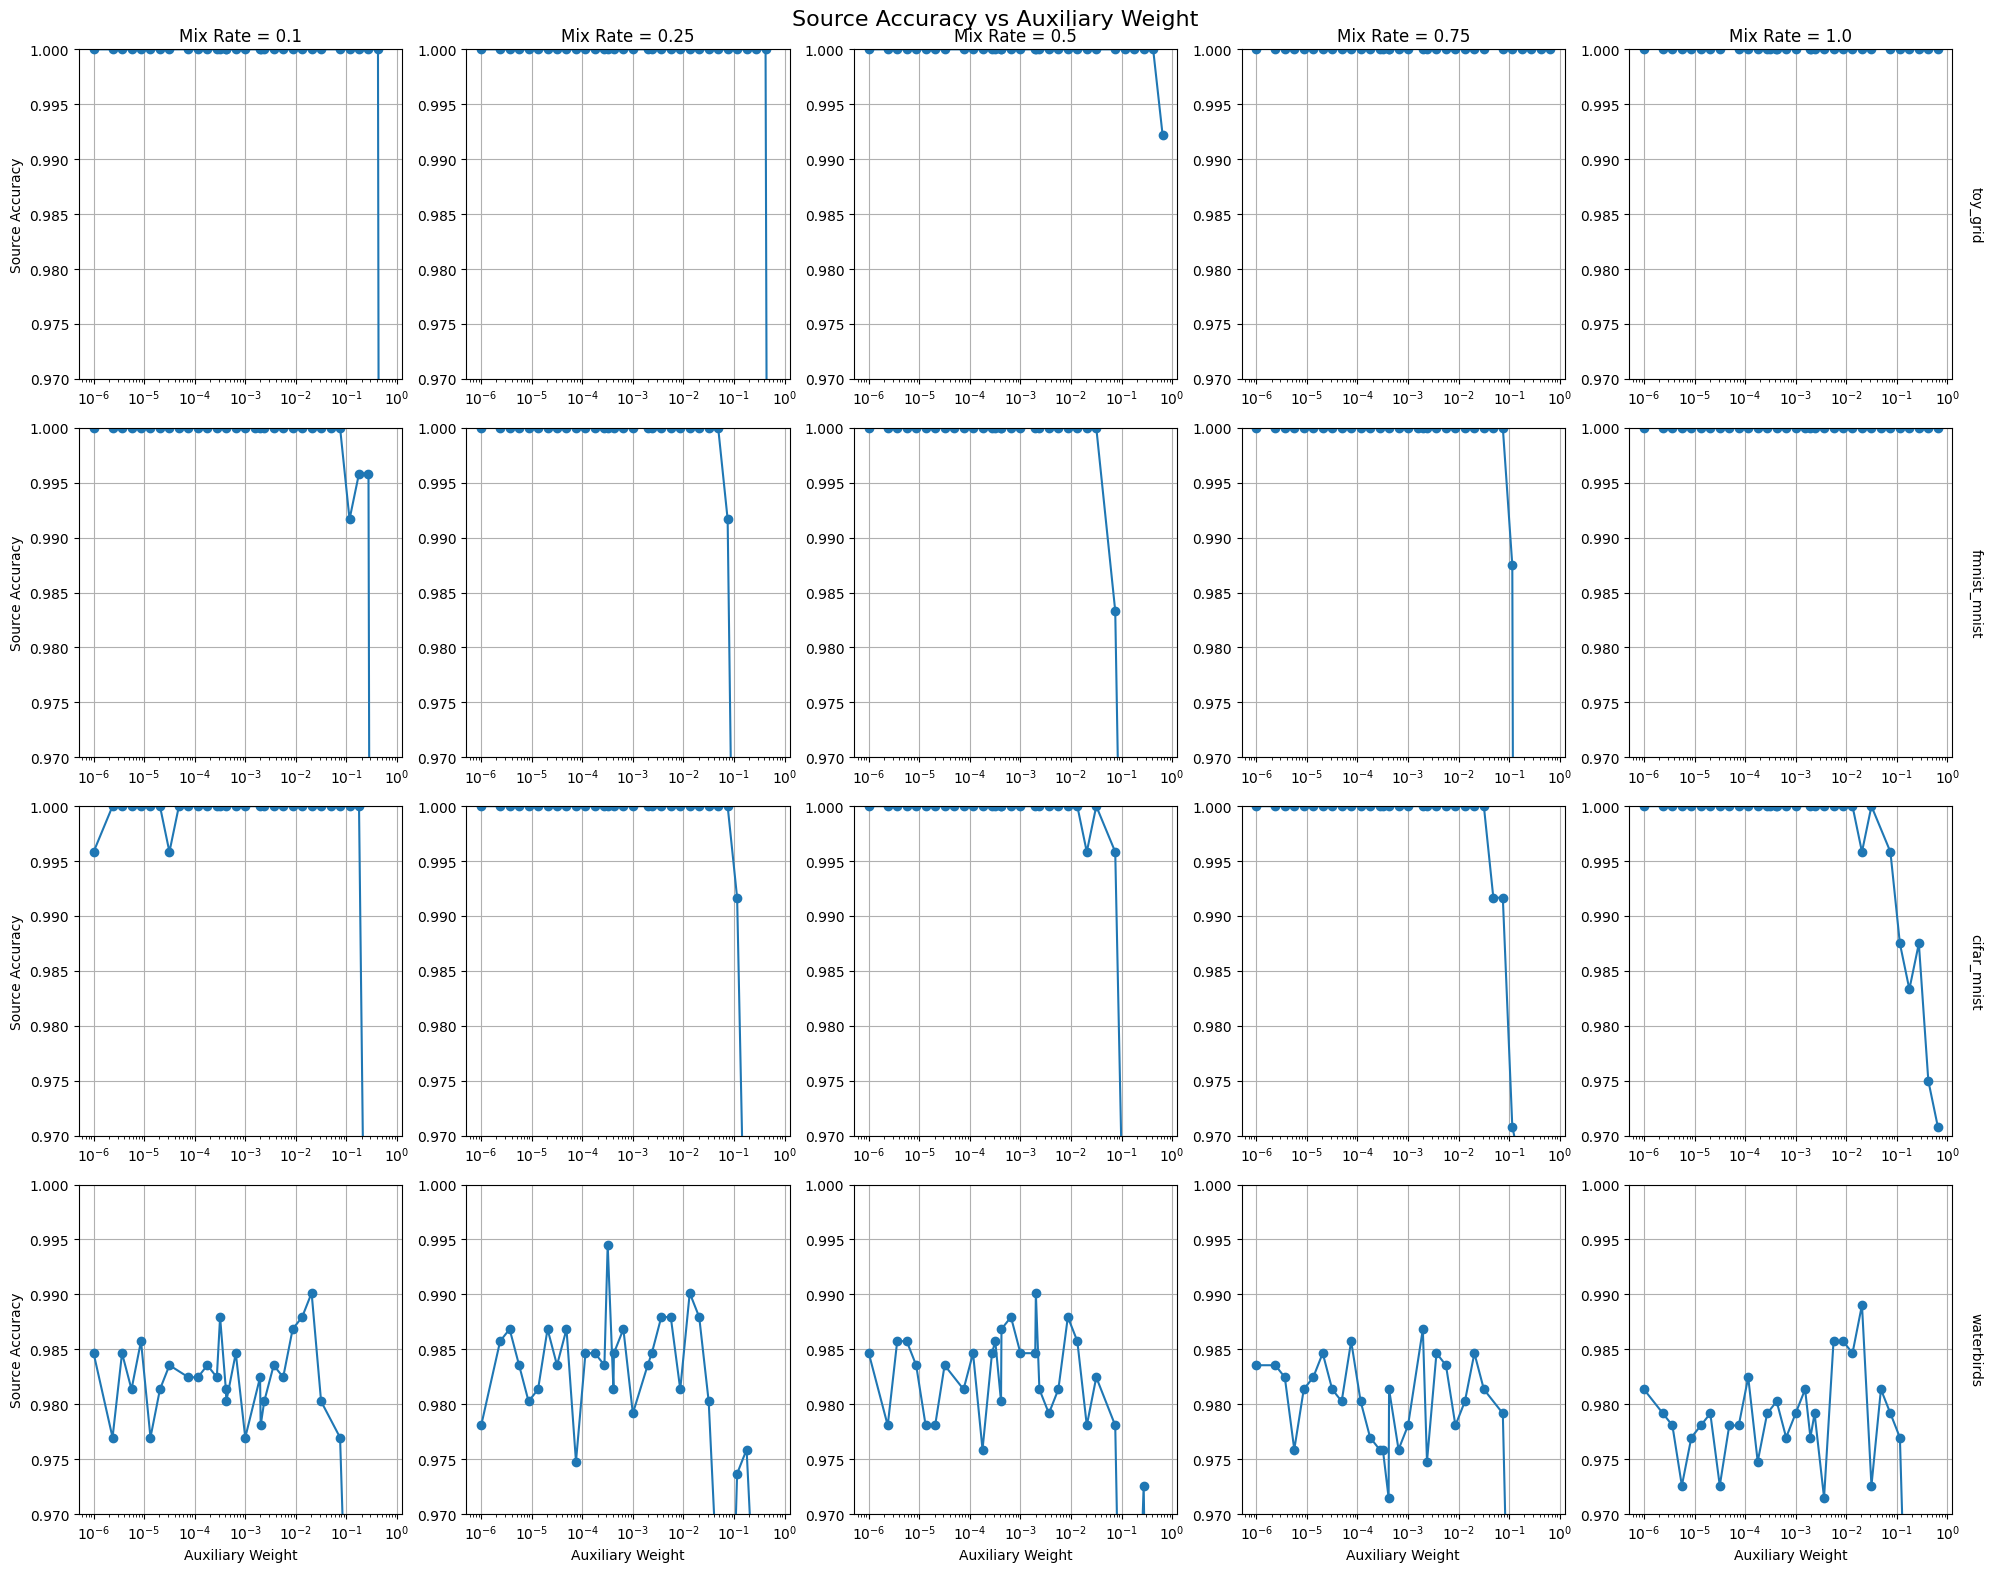

In [6]:
# Create a subplot grid
fig, axes = plt.subplots(len(DATASETS), len(MIX_RATES), figsize=(20, 16))
fig.suptitle('Source Accuracy vs Auxiliary Weight', fontsize=16)

# Iterate through datasets (rows) and mix rates (columns)
for i, dataset in enumerate(DATASETS):
    for j, mix_rate in enumerate(MIX_RATES):
        ax = axes[i, j]
        
        # Filter for specific mix rate and dataset
        dataset_df = df[(df['dataset'] == dataset) & (df['mix_rate'] == mix_rate)]
        
        # Calculate mean and std of source_acc for each aux_weight
        grouped = dataset_df.groupby('aux_weight')['source_acc'].agg(['mean', 'std']).reset_index()
        
        ax.errorbar(grouped['aux_weight'], grouped['mean'], yerr=grouped['std'], 
                   marker='o', capsize=5)
        
        ax.set_xscale('log')
        ax.grid(True)
        
        # Add labels
        if i == len(DATASETS)-1:  # Bottom row
            ax.set_xlabel('Auxiliary Weight')
        if j == 0:  # Leftmost column
            ax.set_ylabel('Source Accuracy')
            
        # Add titles
        if i == 0:  # Top row
            ax.set_title(f'Mix Rate = {mix_rate}')
        if j == len(MIX_RATES)-1:  # Rightmost column
            ax.text(1.05, 0.5, dataset, rotation=-90, 
                   transform=ax.transAxes, va='center')
        
        ax.set_ylim(0.97, 1.0)

plt.tight_layout()
plt.show()

In [ ]:
# conclusion: not much variation with respect to mix rate (maybe this is fine though?)
# toy_grid: 0.4 
# fmnist_mnist: 0.05
# cifar_mnist: 0.01
# waterbirds: 0.01